<a href="https://colab.research.google.com/github/garrettsomers/ManningLLMBook/blob/lora_tutorial/LoRA_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [1]:
#!pip install -U sentencepiece
!pip install -q kaggle torch peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 accelerate openai
!git clone https://github.com/guyfe/Tweetsumm.git

fatal: destination path 'Tweetsumm' already exists and is not an empty directory.


In [2]:
## tweet_sum_processor.py has an issue where it crashes when <3 summaries are
## available. add a small fix:
with open('Tweetsumm/tweet_sum_processor.py', 'r') as file:
    lines = file.readlines()
lines.insert(79, "            if summ is None: continue\n")
with open('Tweetsumm/tweet_sum_processor2.py', 'w') as file:
    file.writelines(lines)

In [3]:
from datasets import Dataset, DatasetDict
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import ast

%matplotlib inline

# Collect and format data

In [4]:
## Upload your kaggle.json cred file.
os.path.exists('~/.kaggle/')

False

In [5]:
!ls -a ~/.kaggle

.  ..  kaggle.json


In [6]:
## determine if this goes in /root or /content
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
## If the data has now been downloaded, retrieve from kaggle
if not os.path.exists('./twcs'):
  !kaggle datasets download -d thoughtvector/customer-support-on-twitter
  !unzip customer-support-on-twitter.zip

In [9]:
## Process the Kaggle data with the TweetSmmm processor
from Tweetsumm.tweet_sum_processor2 import TweetSumProcessor
processor = TweetSumProcessor('./twcs/twcs.csv')

In [10]:
def process_data(file_loc):
    ## Load the tweet conversations
    all_convos = []
    with open(file_loc) as f:
        dialog_with_summaries = processor.get_dialog_with_summaries(f.readlines())
        for i, dialog_with_summary in enumerate(dialog_with_summaries):
            json_format = dialog_with_summary.get_json()
            all_convos.append(json_format)

    ## Process into conversations and summaries
    all_processed = []
    for ac in all_convos:
        ac = json.loads(ac)

        ident = ac['dialog']['dialog_id']
        turns = ac['dialog']['turns']
        convo = ''
        for turn in turns:
            agent = turn['is_agent']
            sent = ' '.join(turn['sentences'])
            sent = ' '.join([t for t in sent.split() if 'https://t.co' not in t])
            if sent[0] == '@':
                sent = ' '.join(sent.split()[1:])

            if agent: convo += 'Agent: '
            else: convo += 'Customer: '
            convo += sent+' \n '

        summaries = [' '.join(summ) for summ in ac['summaries']['abstractive_summaries']]
        all_processed.append([ident,convo,summaries])

    ## Save as dataframe
    df = pd.DataFrame({'id':[p[0] for p in all_processed],
                       'convos':[p[1] for p in all_processed],
                       'summaries':[p[2] for p in all_processed]
                      })
    return df

def create_llama_data(file_loc):
    ## Read in the data and process into conversations
    df = process_data(file_loc)

    ## Create prompts for each combination of conversation + summary
    out = []
    for i in df.to_numpy():
        for j in i[2]:
            question = "### Instruction:\n"\
            + "Read the following conversation between a customer and a customer service agent, and then create a two sentence "\
            + "summary of the conversation, describing the customer's question and the agent's response.\n\n"\
            +f"### Conversation: \n{i[1]}\n\n"\
            + "### Summary: "
            prompt = question + j + ' <END_OF_SECOND_SENTENCE>'
            out.append([i[0],prompt,question,j])

            ## If this is the test set, only collect only one example of each prompt.
            if 'test_tweetsum' in file_loc: break

    return pd.DataFrame({'id':[o[0] for o in out],'text':[o[1] for o in out],'question':[o[2] for o in out],'answer':[o[3] for o in out]})

train_df = create_llama_data('./Tweetsumm/tweet_sum_data_files/final_train_tweetsum.jsonl')
valid_df = create_llama_data('./Tweetsumm/tweet_sum_data_files/final_valid_tweetsum.jsonl')
test_df = create_llama_data('./Tweetsumm/tweet_sum_data_files/final_test_tweetsum.jsonl')

tweetsum_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

In [11]:
tweetsum_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'question', 'answer'],
        num_rows: 2629
    })
    valid: Dataset({
        features: ['id', 'text', 'question', 'answer'],
        num_rows: 356
    })
    test: Dataset({
        features: ['id', 'text', 'question', 'answer'],
        num_rows: 110
    })
})

In [14]:
tweetsum_datasets['test'][1]

{'id': '1d1a6617ae65baa429c2232ccc908840',
 'text': "### Instruction:\nRead the following conversation between a customer and a customer service agent, and then create a two sentence summary of the conversation, describing the customer's question and the agent's response.\n\n### Conversation: \nCustomer: hi , my Acc was linked to an old number. Now I’m asked to verify my Acc , where a code / call wil be sent to my old number. Any way that I can link my Acc to my current number? Pls help \n Agent: Hi there, we are here to help. We will have a specialist contact you about changing your phone number. Thank you. \n Customer: Thanks. Hope to get in touch soon \n Agent: That is no problem. Please let us know if you have any further questions in the meantime. \n Customer: Hi sorry , is it for my account : __email__ \n Agent: Can you please delete this post as it does have personal info in it. We have updated your Case Manager \n Agent: who will be following up with you shortly. Feel free to D

# Imports

In [12]:
import transformers
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from trl import SFTTrainer
from peft import LoraConfig

from huggingface_hub import notebook_login
if not os.path.exists('/root/.cache/huggingface/token'):
    notebook_login()

In [13]:
## Log in with your OpenAI credentials if grading responses with GPT. Otherwise,
## can skip this cell.

import getpass
import openai

openai.api_key = getpass.getpass()

client = openai.OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key=openai.api_key,
)

def submit_prompt_gpt(prompt,gpt_model):
    if gpt_model == '3': model = "gpt-3.5-turbo"
    elif gpt_model == '4': model = "gpt-4"
    else: sys.exit('Invalid gpt model number')

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model
    )
    return chat_completion.choices[0].message.content

def grade_with_gpt(response):
    ## Split the conversation summary into the input and output portions
    try:
        conversation = response.split('### Conversation:')[-1]
        conversation, summary = conversation.split('### Summary:')
        ## Remove the <END_OF_SECOND_SENTENCE> tokens
        if '<END_' in summary:
            summary = summary.split('<END_')[0]
    except:
        gpt_eval = 'failed. score is 0.'
        gpt_score = '(0, 0, 0)'
        return gpt_eval, gpt_score

    gpt_eval = submit_prompt_gpt(f'''I am going to give you a conversation between a Customer and a customer service Agent. Please read the conversation, then read the summary below and answer three questions about the summary:

1) Does the summary of the customer's complaint reasonably match the conversation?
2) Does the summary of the agent's response reasonably match the conversation?
3) Are there exactly two sentences ending in periods in the summary?

Please give you answer to each of these questions. Then, give the summary a score of 1, 2, or 3, depending on how many of the above questions you answered "yes" to.

### Conversation: {conversation}
### Summary: {summary}''',
                            '4')

    gpt_score = submit_prompt_gpt("Please read the following summary and return a python tuple with the scores given to criteria 1, 2, and 3. "\
        +f"Note that 'Yes' is a score of 1, 'No' is a score of 0, and 'Partially' or similar is a score of 0.5: {gpt_eval}\n\nOutput: ",'3')

    return gpt_eval, gpt_score

In [14]:
## Write a file to monitor GPU useage.

if False:
    gpulines = """#! /bin/bash
    #comment: run for 10 seconds, change it as per your use
    its=1000

    for ((i=1; i<=its; i++)) do
        nvidia-smi --format=csv --query-gpu=timestamp,power.draw,utilization.gpu,memory.used,memory.free,fan.speed,temperature.gpu
        nvidia-smi --format=csv --query-gpu=timestamp,power.draw,utilization.gpu,memory.used,memory.free,fan.speed,temperature.gpu >> gpu.log
        sleep 2
    done"""

    open('gpu_usage.sh','w').writelines(gpulines)

# DistilGPT Experiments

## DistilGPT2 -- Base

First, let's look at a smaller LLM. DistilGPT2 is an 84 million parameter model that is tuned with supervision by the 124 million parameter GPT2. It is capable of language generation and response well to fine-tuning. Generate summaries with no fine-tuning first.

In [ ]:
## Define the model
llm_name = 'distilgpt2'

## Create a generator from the base model for inference.
generator_base = pipeline("text-generation",
                     model=llm_name,
                     tokenizer=llm_name,
                     device='cuda:0',
                     max_new_tokens=100)

## Run each test prompt question through
base_responses = []
for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
    with torch.autocast("cuda"):
        base_output = generator_base(theprompt)
    base_responses.append(base_output[0]['generated_text'])
    print(ii,'done')

In [ ]:
## Grade the summaries using GPT-4. The grading rubric is:
##
## 1) Is the description of the customer’s question/complaint reasonably accurate?
## 2) Is the description of the agent’s response reasonably accurate?
## 3) Is the summary exactly two sentences in length?
##
## Give one point for each criteria met, for a total of 3 possible points. Return
## both a textual description of the score, and a tuple with 3 entries giving
## 0, 1, or 0.5 (if the model thought it was partially correct).

base_gpt_evals = []
base_gpt_scores = []
for ii, resp in enumerate(base_responses[:50]):
    gpt_eval, gpt_score = grade_with_gpt(resp)
    base_gpt_evals.append(gpt_eval)
    base_gpt_scores.append(gpt_score)
    print(ii,'done')

base_gpt_results = pd.DataFrame({
    'summary':base_responses[:50],
    'evaluation':base_gpt_evals,
    'scores':base_gpt_scores,
})

base_gpt_results['scores'] = base_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(base_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(base_gpt_results['scores'].tolist()).sum())

Scores per criteria:  [9.  2.5 2. ]
Total score:  13.5


## DistilGPT2 -- Fine-tuned

In [ ]:
## Define and instantiate the model
llm_name = 'distilgpt2'

model = AutoModelForCausalLM.from_pretrained(llm_name)
tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
## Define training arguments
training_args = TrainingArguments(
    output_dir="./sft_test_distilgpt2",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    weight_decay=0.01,
    push_to_hub=False,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1
)

## Instantiate the trl trainer.
sft_trainer = SFTTrainer(
    model,
    train_dataset = tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    args = training_args,
    dataset_text_field = 'text',
    max_seq_length=1024
)

## Train
sft_trainer.train()

Output from the run looked like this:

```
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 [13145/13145 09:39, Epoch 5/5]
Epoch	Training Loss	Validation Loss
1	    2.135600	     2.617715
2	    1.456400	     3.108381
3	    0.976500	     3.485826
4	    0.684200	     3.724089
5	    0.532800	     3.834231
TrainOutput(global_step=13145, training_loss=1.2632515374405295, metrics={'train_runtime': 582.3309, 'train_samples_per_second': 22.573, 'train_steps_per_second': 22.573, 'total_flos': 1272839244595200.0, 'train_loss': 1.2632515374405295, 'epoch': 5.0})
```

This took around 9.5 minutes on a V100 GPU. As of yet there is no optimization on hyperparameters. We now have DistilGPT2 fine-tuned to be more aligned with the summaries provided by the TweetSumm dataset. Now generate summaries from the fine-tuned model.

In [ ]:
## Save models for convenience later.
model.push_to_hub("distilgpt2-tweetsumm-finetune")
tokenizer.push_to_hub("distilgpt2-tweetsumm-finetune")

In [ ]:
## Create a generator from the tuned model for inference.
generator_tuned = pipeline("text-generation",
                     model='gsomers-smarsh/distilgpt2-tweetsumm-finetune4',
                     tokenizer='gsomers-smarsh/distilgpt2-tweetsumm-finetune4',
                     device='cuda:0',
                     max_new_tokens=100)

## Run each test prompt question through
tuned_responses = []
for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
    with torch.autocast("cuda"):
        tuned_output = generator_tuned(theprompt)
    tuned_responses.append(tuned_output[0]['generated_text'])
    print(ii,'done')

In [ ]:
## Grade the summaries using GPT-4. The grading rubric is:
##
## 1) Is the description of the customer’s question/complaint reasonably accurate?
## 2) Is the description of the agent’s response reasonably accurate?
## 3) Is the summary exactly two sentences in length?
##
## Give one point for each criteria met, for a total of 3 possible points. Return
## both a textual description of the score, and a tuple with 3 entries giving
## 0, 1, or 0.5 (if the model thought it was partially correct).

tuned_gpt_evals = []
tuned_gpt_scores = []
for ii, resp in enumerate(tuned_responses[:50]):
    gpt_eval, gpt_score = grade_with_gpt(resp)
    tuned_gpt_evals.append(gpt_eval)
    tuned_gpt_scores.append(gpt_score)
    print(ii,'done')

tuned_gpt_results = pd.DataFrame({
    'summary':tuned_responses[:50],
    'evaluation':tuned_gpt_evals,
    'scores':tuned_gpt_scores,
})

tuned_gpt_results['scores'] = tuned_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(tuned_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(tuned_gpt_results['scores'].tolist()).sum())

Scores per criteria:  [14.  13.5 31.5]
Total score:  59.0


## DistilGPT2 -- LoRA-tuned

In [ ]:
## Define and instantiate the model

llm_name = 'distilgpt2'

model = AutoModelForCausalLM.from_pretrained(llm_name)
tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## Define the LoRA or QLoRA parameters. This uses a LoraConfig object which is
## passed to the trl trainer at training time. For QLoRA, you also create a
## BitsAndBytesConfig object which is passed when the base model instantiated
## so that it can be quantized to 4-bit.

if False: ## LoRA
    ## LoRA parameters
    ## Note these numbers are the default suggested in the trl documentation about fine-tuning with LORA
    ## https://huggingface.co/docs/trl/main/en/lora_tuning_peft
    lora_params = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    ## Load model with LoRA parameters
    model = AutoModelForCausalLM.from_pretrained(
        llm_name,
        device_map={"":0}
    )
    model.config.use_cache = False

else: ## QLoRA
    lora_params = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    # Quantization parameters
    bnb_params = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    ## Load model with LoRA parameters
    model = AutoModelForCausalLM.from_pretrained(
        llm_name,
        quantization_config=bnb_params,
        device_map={"":0}
    )
    model.config.use_cache = False

In [ ]:
## Define training arguments
training_args = TrainingArguments(
    output_dir="./qlora_test_distilgpt2",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    weight_decay=0.01,
    push_to_hub=False,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    fp16=False,
    bf16=False,
)

## Instantiate the trl trainer.
sft_trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    args = training_args,
    dataset_text_field = 'text',
    max_seq_length = 1024,
    peft_config=lora_params,
)

# Train
sft_trainer.train()

```
Map: 100%
2629/2629 [00:00<00:00, 3130.99 examples/s]
Map: 100%
356/356 [00:00<00:00, 2920.50 examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
 [6570/6570 13:17, Epoch 4/5]
Epoch	Training Loss	Validation Loss
0	2.933800	2.728444
2	2.794600	2.668123
2	2.771500	2.629842
4	2.720500	2.616652
4	2.711100	2.612762
TrainOutput(global_step=6570, training_loss=2.8115940088187905, metrics={'train_runtime': 798.0339, 'train_samples_per_second': 16.472, 'train_steps_per_second': 8.233, 'total_flos': 656155432525824.0, 'train_loss': 2.8115940088187905, 'epoch': 5.0})
```

In [ ]:
## Push to hub
sft_trainer.model.push_to_hub('gsomers-smarsh/distilgpt2-tweetsumm-qlora')
tokenizer.push_to_hub('gsomers-smarsh/distilgpt2-tweetsumm-qlora')

In [ ]:
# ## Load from hub and combine LoRA weights with base model
# lora_config = LoraConfig.from_pretrained("gsomers-smarsh/distilgpt2-tweetsumm-qlora-finetune")
# lora_tokenizer = AutoTokenizer.from_pretrained('gsomers-smarsh/distilgpt2-tweetsumm-lora-finetune')
# lora_base_model = AutoModelForCausalLM.from_pretrained(
#     lora_config.base_model_name_or_path,
#     device_map={"":0})

# from peft import get_peft_model
# lora_model = get_peft_model(lora_base_model,lora_config)
# lora_model.config.use_cache = False

In [ ]:
## Create a generator from the lora-tuned model for inference.
generator_lora = pipeline("text-generation",
                     model=sft_trainer.model,
                     tokenizer=tokenizer,
                     device='cuda:0',
                     max_new_tokens=100)

## Generate a summary for each test set conversation
lora_responses = []
for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
    with torch.autocast("cuda"):
        lora_output = generator_lora(theprompt)
    lora_responses.append(lora_output[0]['generated_text'])
    print(ii,'done')

In [ ]:
## Grade the summaries using GPT-4. The grading rubric is:
##
## 1) Is the description of the customer’s question/complaint reasonably accurate?
## 2) Is the description of the agent’s response reasonably accurate?
## 3) Is the summary exactly two sentences in length?
##
## Give one point for each criteria met, for a total of 3 possible points. Return
## both a textual description of the score, and a tuple with 3 entries giving
## 0, 1, or 0.5 (if the model thought it was partially correct).

lora_gpt_evals = []
lora_gpt_scores = []
for ii, resp in enumerate(lora_responses[:50]):
    gpt_eval, gpt_score = grade_with_gpt(resp)
    lora_gpt_evals.append(gpt_eval)
    lora_gpt_scores.append(gpt_score)
    print(ii,'done')

lora_gpt_results = pd.DataFrame({
    'summary':lora_responses[:50],
    'evaluation':lora_gpt_evals,
    'scores':lora_gpt_scores,
})

lora_gpt_results['scores'] = lora_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(lora_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(lora_gpt_results['scores'].tolist()).sum())

# Llama 2 Experiments

## Llama 2 -- Base
Lacking more data, we want to move to a larger LLM to get better transfer learning basis.[link text](https:// [link text](https://))

In [ ]:
llm_name = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
llm_name = 'meta-llama/Llama-2-7b-hf'

## Create a generatpr from the base model for inference.
generator_base = pipeline("text-generation",
                     model=llm_name,
                     tokenizer=llm_name,
                     torch_dtype=torch.float16,
                     device='cuda:0',
                     max_new_tokens=100)

## Run each test prompt question through
base_responses = []
for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
    with torch.autocast("cuda"):
        base_output = generator_base(theprompt)
    base_responses.append(base_output[0]['generated_text'])
    print(ii,'done')

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
#base_gpt_evals = []
#base_gpt_scores = []
for ii, resp in enumerate(base_responses[:50]):
    if ii<=19: continue
    gpt_eval, gpt_score = grade_with_gpt(resp)
    base_gpt_evals.append(gpt_eval)
    base_gpt_scores.append(gpt_score)
    print(ii,'done')
    time.sleep(5)

base_gpt_results = pd.DataFrame({
    'summary':base_responses[:50],
    'evaluation':base_gpt_evals,
    'scores':base_gpt_scores,
})

base_gpt_results['scores'] = base_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(base_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(base_gpt_results['scores'].tolist()).sum())

In [ ]:
base_gpt_results.to_csv('llama2-7b_base_evaluations.csv',index=False)


## Llama 2 -- Fine-tuning

In [ ]:
model = AutoModelForCausalLM.from_pretrained(llm_name)

training_args = TrainingArguments(
    output_dir="./sft_test_llama2",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    weight_decay=0.01,
    push_to_hub=False,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2
)

sft_trainer = SFTTrainer(
    model,
    train_dataset = tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    args = training_args,
    dataset_text_field = 'text',
    max_seq_length=1024
)

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

OutOfMemoryError: ignored

## Llama 2 -- LoRA-tuning

In [15]:
# First do LoRA
base_model_name = "meta-llama/Llama-2-7b-hf"

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

if True: ## LoRA
    # Model
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        load_in_8bit=True,
        device_map={"": 0}
    )
    base_model.config.use_cache = False

else: ## QLora

    # Quantization Config
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=False
    )

    # Model
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        quantization_config=quant_config,
        device_map={"": 0}
    )
    base_model.config.use_cache = False
    base_model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
# LoRA Config
peft_parameters = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Training Params
train_params = TrainingArguments(
    output_dir="./results_modified",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params,
    peft_config=peft_parameters
)

In [ ]:
fine_tuning.train()

```
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
 [1315/1315 1:14:56, Epoch 1/1]
Step	Training Loss
25	1.980000
50	1.602700
75	1.760700
100	1.573600
125	1.775300
850	1.484300
875	1.614600
975	1.692300
1250	1.365000
1275	1.562000
1300	1.337100

TrainOutput(global_step=1315, training_loss=1.5676544102425811, metrics={'train_runtime': 4506.7679, 'train_samples_per_second': 0.583, 'train_steps_per_second': 0.292, 'total_flos': 4.479643550773248e+16, 'train_loss': 1.5676544102425811, 'epoch': 1.0})
```

In [ ]:
## Create a generatpr from the base model for inference.
generator_lora = pipeline("text-generation",
                     model=fine_tuning.model,
                     tokenizer=llama_tokenizer,
                     device='cuda:0',
                     max_new_tokens=100)

## Run each test prompt question through
lora_responses = []
for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
    with torch.autocast("cuda"):
        lora_output = generator_lora(theprompt)
    lora_responses.append(lora_output[0]['generated_text'])
    print(ii,'done')

In [37]:
## Grade the summaries using GPT-4. The grading rubric is:
##
## 1) Is the description of the customer’s question/complaint reasonably accurate?
## 2) Is the description of the agent’s response reasonably accurate?
## 3) Is the summary exactly two sentences in length?
##
## Give one point for each criteria met, for a total of 3 possible points. Return
## both a textual description of the score, and a tuple with 3 entries giving
## 0, 1, or 0.5 (if the model thought it was partially correct).

lora_gpt_evals = []
lora_gpt_scores = []
for ii, resp in enumerate(lora_responses[:50]):
    gpt_eval, gpt_score = grade_with_gpt(resp)
    lora_gpt_evals.append(gpt_eval)
    lora_gpt_scores.append(gpt_score)
    print(ii,'done')

lora_gpt_results = pd.DataFrame({
    'summary':lora_responses[:50],
    'evaluation':lora_gpt_evals,
    'scores':lora_gpt_scores,
})

lora_gpt_results['scores'] = lora_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(lora_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(lora_gpt_results['scores'].tolist()).sum())

Scores per criteria:  [45. 43. 39.]
Total score:  127.0


## Llama 2 -- QLoRA-tuning

In [ ]:
# QLoRA
base_model_name = "meta-llama/Llama-2-7b-hf"

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
llama_tokenizer.pad_token = llama_tokenizer.eos_token
llama_tokenizer.padding_side = "right"  # Fix for fp16

# Quantization Config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False
)

# Model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

In [ ]:
# LoRA Config
peft_parameters = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Training Params
train_params = TrainingArguments(
    output_dir="./results_modified",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)

# Trainer
fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    dataset_text_field="text",
    tokenizer=llama_tokenizer,
    args=train_params,
    peft_config=peft_parameters
)

In [ ]:
fine_tuning.train()

```
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
 [1315/1315 21:17, Epoch 1/1]
Step	Training Loss
25	2.014100
50	1.636900
75	1.770500
100	1.582300
450	1.482600
475	1.646500
500	1.544900
525	1.702500
550	1.546200
1150	1.426400
1175	1.542800
1200	1.413200
1225	1.575600
1250	1.360900
1275	1.568300
1300	1.336800

TrainOutput(global_step=1315, training_loss=1.5749566038298517, metrics={'train_runtime': 1279.8114, 'train_samples_per_second': 2.054, 'train_steps_per_second': 1.027, 'total_flos': 2.285736772320461e+16, 'train_loss': 1.5749566038298517, 'epoch': 1.0})
```

In [ ]:
## Create a generator from the base model for inference.
generator_qlora = pipeline("text-generation",
                     model=fine_tuning.model,
                     tokenizer=llama_tokenizer,
                     device='cuda:0',
                     max_new_tokens=100)

## Run each test prompt question through
qlora_responses = []
with torch.autocast("cuda"):
    for ii, theprompt in enumerate(tweetsum_datasets['test']['question']):
        qlora_output = generator_qlora(theprompt)
        qlora_responses.append(qlora_output[0]['generated_text'])
        print(ii,'done')

In [ ]:
## Grade the summaries using GPT-4. The grading rubric is:
##
## 1) Is the description of the customer’s question/complaint reasonably accurate?
## 2) Is the description of the agent’s response reasonably accurate?
## 3) Is the summary exactly two sentences in length?
##
## Give one point for each criteria met, for a total of 3 possible points. Return
## both a textual description of the score, and a tuple with 3 entries giving
## 0, 1, or 0.5 (if the model thought it was partially correct).

qlora_gpt_evals = []
qlora_gpt_scores = []
for ii, resp in enumerate(qlora_responses[:50]):
    gpt_eval, gpt_score = grade_with_gpt(resp)
    qlora_gpt_evals.append(gpt_eval)
    qlora_gpt_scores.append(gpt_score)
    print(ii,'done')

qlora_gpt_results = pd.DataFrame({
    'summary':qlora_responses[:50],
    'evaluation':qlora_gpt_evals,
    'scores':qlora_gpt_scores,
})

qlora_gpt_results['scores'] = qlora_gpt_results.scores.apply(lambda x: ast.literal_eval(x))
print('Scores per criteria: ',np.array(qlora_gpt_results['scores'].tolist()).sum(axis=0))
print('Total score: ',np.array(qlora_gpt_results['scores'].tolist()).sum())

# Now lets read back in model from the hub

In [ ]:
## If we need a reminder of the BitsAndBites config
from huggingface_hub import hf_hub_download
readme_path = hf_hub_download(repo_id='gsomers-smarsh/llama2-7b-tweetsumm-qlora-finetune', filename='README.md')
! cat $readme_path

---
library_name: peft
---
## Training procedure


The following `bitsandbytes` quantization config was used during training:
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules: None
- llm_int8_enable_fp32_cpu_offload: False
- llm_int8_has_fp16_weight: False
- bnb_4bit_quant_type: nf4
- bnb_4bit_use_double_quant: False
- bnb_4bit_compute_dtype: float16
### Framework versions


- PEFT 0.4.0


In [ ]:
lora2_config = LoraConfig.from_pretrained("gsomers-smarsh/llama2-7b-tweetsumm-qlora-finetune")
bnb2_config = BitsAndBytesConfig(
    load_in_8bit = False,
    load_in_4bit = True,
    llm_int8_threshold = 6.0,
    llm_int8_skip_modules = None,
    llm_int8_enable_fp32_cpu_offload = False,
    llm_int8_has_fp16_weight = False,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_use_double_quant = False,
    bnb_4bit_compute_dtype = torch.float16,
)

In [ ]:
llama2_tokenizer = AutoTokenizer.from_pretrained('gsomers-smarsh/llama2-7b-tweetsumm-qlora-finetune')
model2 = AutoModelForCausalLM.from_pretrained(
    lora2_config.base_model_name_or_path,
    quantization_config=bnb2_config,
    device_map={"":0})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import get_peft_model
qlora_model = get_peft_model(model2,lora2_config)

In [ ]:
base_model_name = "NousResearch/Llama-2-7b-hf"

# Tokenizer
llama_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
generator_base = pipeline("text-generation",
                     model="NousResearch/Llama-2-7b-hf",
                     tokenizer=llama_tokenizer,
                     device='cuda:0',
                     max_new_tokens=75)

# generator_tuned = pipeline("text-generation",
#                      model=qlora_model,
#                      tokenizer=llama2_tokenizer,
#                      device='cuda:0',
#                      max_new_tokens=75)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
tweetsum_datasets['test'][0]

{'id': 'bbde6d8ec7c39c4551da1ff6024f997b',
 'text': "[INST] ### Instruction:\nRead the following conversation between a customer and a customer service agent, and then create a two sentence summary of the conversation, describing the customer's question and the agent's response.\n\n### Conversation: \nCustomer: My watchlist is not updating with new episodes (past couple days). Any idea why? \n Agent: Apologies for the trouble, Norlene! We're looking into this. In the meantime, try navigating to the season / episode manually. \n Customer: Tried logging out/back in, that didn’t help \n Agent: Sorry! 😔 We assure you that our team is working hard to investigate, and we hope to have a fix ready soon! \n Customer: Thank you! Some shows updated overnight, but others did not... \n Agent: We definitely understand, Norlene. For now, we recommend checking the show page for these shows as the new eps will be there \n Customer: As of this morning, the problem seems to be resolved. Watchlist updated

In [ ]:
ii = 0

theprompt = tweetsum_datasets['test'][ii]['question']
print(theprompt)
print('\nToken length = ',len(llama2_tokenizer.encode(theprompt)))
print('(' + tweetsum_datasets['test'][ii]['answer'] + ')')



[INST] ### Instruction:
Read the following conversation between a customer and a customer service agent, and then create a two sentence summary of the conversation, describing the customer's question and the agent's response.

### Conversation: 
Customer: My watchlist is not updating with new episodes (past couple days). Any idea why? 
 Agent: Apologies for the trouble, Norlene! We're looking into this. In the meantime, try navigating to the season / episode manually. 
 Customer: Tried logging out/back in, that didn’t help 
 Agent: Sorry! 😔 We assure you that our team is working hard to investigate, and we hope to have a fix ready soon! 
 Customer: Thank you! Some shows updated overnight, but others did not... 
 Agent: We definitely understand, Norlene. For now, we recommend checking the show page for these shows as the new eps will be there 
 Customer: As of this morning, the problem seems to be resolved. Watchlist updated overnight with all new episodes. Thank you for your attention 

In [ ]:
base_output = generator_tuned("""[INST] ### Instruction:
Read the following conversation between a customer and a customer service agent, and then write one sentence describing the customer's complaint, and one sentence summarizing the agent's response and resolution, and then stop.

### Conversation:
Customer: My watchlist is not updating with new episodes (past couple days). Any idea why?
 Agent: Apologies for the trouble, Norlene! We're looking into this. In the meantime, try navigating to the season / episode manually.
 Customer: Tried logging out/back in, that didn’t help
 Agent: Sorry! 😔 We assure you that our team is working hard to investigate, and we hope to have a fix ready soon!
 Customer: Thank you! Some shows updated overnight, but others did not...
 Agent: We definitely understand, Norlene. For now, we recommend checking the show page for these shows as the new eps will be there
 Customer: As of this morning, the problem seems to be resolved. Watchlist updated overnight with all new episodes. Thank you for your attention to this matter! I love Hulu 💚
 Agent: Awesome! That's what we love to hear. If you happen to need anything else, we'll be here to support! 💚
 [\INST]

### Summary: """)
query, base_response = base_output[0]['generated_text'].split('[\\INST]\n\n')
print(base_response)

### Summary: 
The customer is complaining that her watchlist is not updating with new episodes. The customer service agent apologizes for the trouble and suggests that the customer try navigating to the season / episode manually. The customer tries logging out/back in, but that doesn't help. The customer service agent apologizes and assures the customer that their team is working hard to


In [ ]:
llm_name = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.padding_side = 'right'

In [ ]:
if True: ## LoRA
    ## LoRA parameters
    ## Note these numbers are the default suggested in the trl documentation about fine-tuning with LORA
    ## https://huggingface.co/docs/trl/main/en/lora_tuning_peft
    lora_params = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    ## Load model with LoRA parameters
    model = AutoModelForCausalLM.from_pretrained(
        llm_name,
        device_map={"":0}
    )
    base_model.config.use_cache = False


else: ## QLoRA
    # Quantization parameters
    bnb_params = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    qlora_params = LoraConfig(
        r=16,#8,
        lora_alpha=32,#16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = AutoModelForCausalLM.from_pretrained(
        llm_name,
        quantization_config=bnb_params,
        #device_map='auto'
    )
    base_model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

In [ ]:
#Training Params
training_args = TrainingArguments(
    output_dir="./results_modified",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
 #   save_steps=25,
 #   logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
 #   group_by_length=True,
 #   lr_scheduler_type="constant",
 #   report_to="tensorboard"
)

# training_args = TrainingArguments(
#     output_dir="./lora_test_llama2",
#     #evaluation_strategy="epoch",
#     optim="paged_adamw_32bit",
#     learning_rate=2e-4,
#     weight_decay=0.01,
#     push_to_hub=False,
#     max_steps = 1000,
#     per_device_train_batch_size=1,
#     gradient_accumulation_steps=2,
#     fp16=False,
#     bf16=False,
# )

# Trainer
sft_trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tweetsum_datasets['train'],
    eval_dataset = tweetsum_datasets['valid'],
    args = training_args,
    dataset_text_field = 'text',
    max_seq_length = 1024,
    peft_config=qlora_params,
)

Map:   0%|          | 0/2629 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

In [ ]:
# Training
sft_trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


RuntimeError: ignored

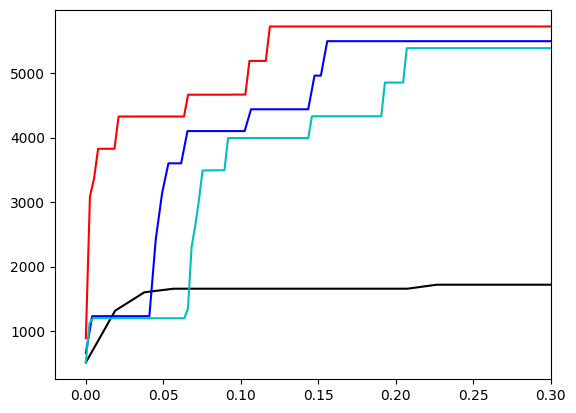

In [ ]:
def read_gpu_info(file_loc):
    df = pd.read_csv(file_loc)
    df = df[~df.duplicated(keep=False)].reset_index(drop=True)
    df['utilization'] = df[' utilization.gpu [%]'].apply(lambda x: int(x.replace('%','')))
    df['mem_used (MiB)'] = df[' memory.used [MiB]'].apply(lambda x: float(x.replace('MiB','')))
    df['mem_free (MiB)'] = df[' memory.free [MiB]'].apply(lambda x: float(x.replace('MiB','')))

    df = df[df['mem_used (MiB)'] >= 3.].reset_index(drop=True)
    df['step'] = df.index
    df['frac'] = df.step.astype(float)/len(df)
    df = df[df['mem_used (MiB)'] >= 3.]
    return df[['timestamp','step','frac','utilization','mem_used (MiB)','mem_free (MiB)']]

gpubase = read_gpu_info('gpu_base_distilgpt2_inf.log')
gputuned = read_gpu_info('gpu_tuning_distilgpt2_trainig_inf.log')
gpulora = read_gpu_info('gpu_lora_distilgpt2_training_inf.log')
gpuqlora = read_gpu_info('gpu_qlora_distilgpt2_training.log')

plt.figure()
plt.plot(gpubase.frac,gpubase['mem_used (MiB)'],ls='-',color='k')
#plt.plot(gpubase.index,gpubase[' utilization.gpu [%]'],ls='--',color='k')
plt.plot(gputuned.frac,gputuned['mem_used (MiB)'],ls='-',color='r')
plt.plot(gpulora.frac,gpulora['mem_used (MiB)'],ls='-',color='b')
plt.plot(gpuqlora.frac,gpuqlora['mem_used (MiB)'],ls='-',color='c')

plt.xlim(-0.02,0.3)
plt.show()